In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("unified_punjab_crop_yield_dataset.csv")

In [11]:
drop_cols = []

# Soil pH extraction if ph_range exists
if "ph_range" in df.columns:
    df["soil_ph"] = df["ph_range"].str.extract(r"(\d+\.\d+).*?(\d+\.\d+)").astype(float).mean(axis=1)
    drop_cols.append("ph_range")

# Convert monsoon onset & end into day-of-year integers if available
if "typical_monsoon_onset" in df.columns:
    df["monsoon_onset_doy"] = pd.to_datetime(df["typical_monsoon_onset"], errors="coerce").dt.dayofyear
    drop_cols.append("typical_monsoon_onset")

if "typical_monsoon_end" in df.columns:
    df["monsoon_end_doy"] = pd.to_datetime(df["typical_monsoon_end"], errors="coerce").dt.dayofyear
    drop_cols.append("typical_monsoon_end")

# Common columns to drop if present
drop_cols += ["sowing_date","harvest_date","notes",
              "ndvi.early_from_ndvi","ndvi.mid_from_ndvi","ndvi.late_from_ndvi"]

df = df.drop(columns=drop_cols, errors="ignore")

# Encode categorical variables safely
for col in ["soil_type","district","season","crop"]:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [12]:
if "estimated_yield_kg_per_ha" not in df.columns:
    raise ValueError("Target column 'estimated_yield_kg_per_ha' not found in dataset!")

X = df.drop(columns=["estimated_yield_kg_per_ha"])
y = df["estimated_yield_kg_per_ha"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

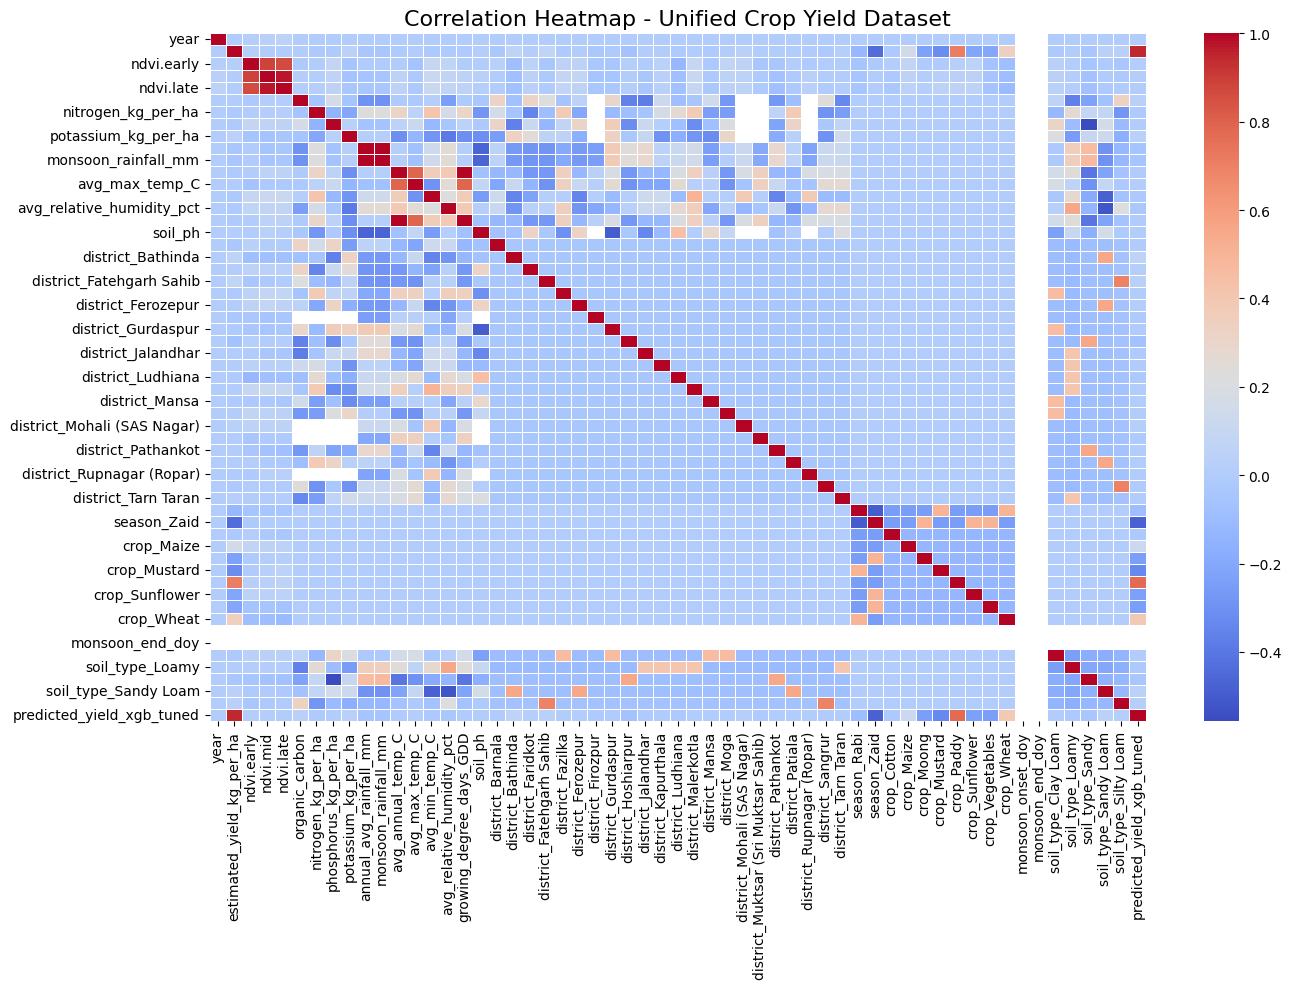

In [29]:
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,   # set to True if you want numbers inside cells
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap - Unified Crop Yield Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

In [15]:
xgb = XGBRegressor(
    random_state=42,
    tree_method="hist",   # fast training
    enable_categorical=False
)

In [16]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8], 'n_estimators': [200, 400],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

/tmp/ipython-input-596602927.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(15), palette="viridis")


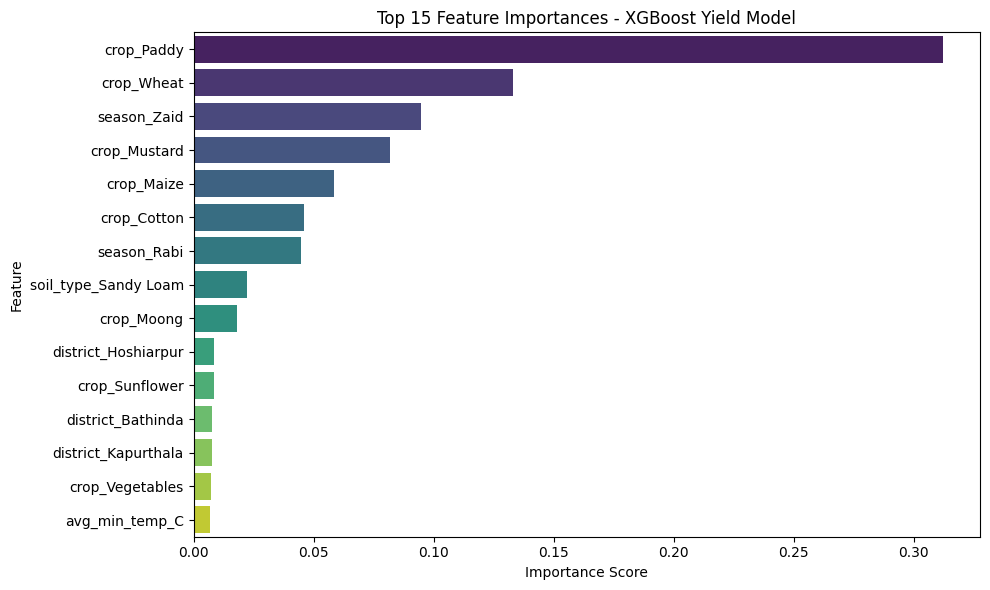

In [26]:
feature_importances = best_xgb.feature_importances_
features = X.columns

# Create DataFrame
fi_df = pd.DataFrame({
    "feature": features,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=fi_df.head(15), palette="viridis")
plt.title("Top 15 Feature Importances - XGBoost Yield Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [18]:
print("Best Params:", grid_search.best_params_)

Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}


In [19]:
best_xgb = grid_search.best_estimator_

In [20]:
y_pred = best_xgb.predict(X_test)

In [22]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))   # <-- manual square root
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\nFine-tuned XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Fine-tuned XGBoost Performance:
MAE: 277.76
RMSE: 351.29
MAPE: 11.57%


In [24]:
df["predicted_yield_xgb_tuned"] = best_xgb.predict(X)
df.to_csv("unified_punjab_crop_yield_with_xgb_tuned.csv", index=False)
print("\nSaved tuned predictions to: unified_punjab_crop_yield_with_xgb_tuned.csv")


Saved tuned predictions to: unified_punjab_crop_yield_with_xgb_tuned.csv


In [27]:
joblib.dump(best_xgb, "sihm_1.joblib")

['sihm_1.joblib']

In [28]:
from google.colab import files

files.download("unified_punjab_crop_yield_with_xgb_tuned.csv")

files.download("sihm_1.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import pandas as pd
from joblib import load

# Load the model
model = load('sihm_1.joblib')

# Get the model's expected features
expected_features = model.get_booster().feature_names

# Create a single-row input with default/0 values
example_data = pd.DataFrame(columns=expected_features)
example_data.loc[0] = 0  # initialize all to 0

# Fill numeric features with example values
example_data.loc[0, 'year'] = 2025
example_data.loc[0, 'ndvi.early'] = 0.45
example_data.loc[0, 'ndvi.mid'] = 0.55
example_data.loc[0, 'ndvi.late'] = 0.60
example_data.loc[0, 'organic_carbon'] = 0.8
example_data.loc[0, 'nitrogen_kg_per_ha'] = 120
example_data.loc[0, 'phosphorus_kg_per_ha'] = 50
example_data.loc[0, 'potassium_kg_per_ha'] = 30
example_data.loc[0, 'annual_avg_rainfall_mm'] = 800
example_data.loc[0, 'monsoon_rainfall_mm'] = 500
example_data.loc[0, 'avg_annual_temp_C'] = 28
example_data.loc[0, 'avg_max_temp_C'] = 35
example_data.loc[0, 'avg_min_temp_C'] = 20
example_data.loc[0, 'avg_relative_humidity_pct'] = 65
example_data.loc[0, 'growing_degree_days_GDD'] = 2000
example_data.loc[0, 'soil_ph'] = 6.5
example_data.loc[0, 'district_Barnala'] = 1        # Example district
example_data.loc[0, 'season_Rabi'] = 1             # Example season
example_data.loc[0, 'crop_Wheat'] = 1             # Example crop
example_data.loc[0, 'soil_type_Loamy'] = 1        # Example soil type

# Predict
predicted_yield = model.predict(example_data)
print(f"Predicted crop yield: {predicted_yield[0]}")


Predicted crop yield: 3406.5576171875


/tmp/ipython-input-2367543958.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  example_data.loc[0, 'ndvi.early'] = 0.45
/tmp/ipython-input-2367543958.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  example_data.loc[0, 'ndvi.mid'] = 0.55
/tmp/ipython-input-2367543958.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  example_data.loc[0, 'ndvi.late'] = 0.60
/tmp/ipython-input-2367543958.py:19: FutureWarning: Setting an item of incompatible dtype is depre